# toledomudhens Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 28, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 59 # toledomudhens

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              10165 non-null  int64  
 1   dimCustomerMasterId       10165 non-null  int64  
 2   customerNumber            10163 non-null  object 
 3   year                      10165 non-null  object 
 4   productGrouping           10165 non-null  object 
 5   totalSpent                10165 non-null  float64
 6   recentDate                10165 non-null  object 
 7   attendancePercent         10165 non-null  float64
 8   renewedBeforeDays         10165 non-null  int64  
 9   isBuyer                   10165 non-null  object 
 10  source_tenure             10165 non-null  int64  
 11  tenure                    10165 non-null  int64  
 12  distToVenue               10165 non-null  float64
 13  totalGames                10165 non-null  int64  
 14  recenc

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          10165 non-null  int64  
 1   dimCustomerMasterId   10165 non-null  int64  
 2   customerNumber        10163 non-null  object 
 3   year                  10165 non-null  object 
 4   productGrouping       10165 non-null  object 
 5   totalSpent            10165 non-null  float64
 6   recentDate            10165 non-null  object 
 7   attendancePercent     10165 non-null  float64
 8   renewedBeforeDays     10165 non-null  int64  
 9   isBuyer               10165 non-null  object 
 10  source_tenure         10165 non-null  int64  
 11  tenure                10165 non-null  int64  
 12  distToVenue           10165 non-null  float64
 13  totalGames            10165 non-null  int64  
 14  recency               10165 non-null  int64  
 15  missed_games_1     

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (9148, 47)
Unseen Data For Predictions: (1017, 47)
Data for Modeling (A Class): (9148, 47)
Unseen Data For Predictions: (1017, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(10165, 18)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  10165 non-null  int64  
 1   totalSpent           10165 non-null  float64
 2   attendancePercent    10165 non-null  float64
 3   renewedBeforeDays    10165 non-null  int64  
 4   source_tenure        10165 non-null  int64  
 5   tenure               10165 non-null  int64  
 6   totalGames           10165 non-null  int64  
 7   recency              10165 non-null  int64  
 8   missed_games_1       10165 non-null  int64  
 9   missed_games_2       10165 non-null  int64  
 10  missed_games_over_2  10165 non-null  int64  
 11  isNextYear_Buyer     10165 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 953.1 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [9]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.03,0.08,-0.01,-0.05,-0.07,0.10,0.02,0.09,0.07,0.03,-0.07
totalSpent,0.03,1.00,-0.00,0.16,0.17,0.25,0.17,0.04,-0.03,0.07,0.30,0.09
attendancePercent,0.08,-0.00,1.00,-0.13,0.22,0.47,0.59,0.13,0.42,0.33,0.12,-0.23
renewedBeforeDays,-0.01,0.16,-0.13,1.00,0.09,0.07,-0.09,-0.05,-0.17,-0.09,0.04,0.19
source_tenure,-0.05,0.17,0.22,0.09,1.00,0.71,0.20,0.10,0.03,0.09,0.23,-0.09
tenure,-0.07,0.25,0.47,0.07,0.71,1.00,0.41,0.21,0.16,0.23,0.36,-0.20
totalGames,0.10,0.17,0.59,-0.09,0.20,0.41,1.00,0.23,0.69,0.64,0.57,-0.18
recency,0.02,0.04,0.13,-0.05,0.10,0.21,0.23,1.00,0.13,0.17,0.31,-0.09
missed_games_1,0.09,-0.03,0.42,-0.17,0.03,0.16,0.69,0.13,1.00,0.46,0.16,-0.28
missed_games_2,0.07,0.07,0.33,-0.09,0.09,0.23,0.64,0.17,0.46,1.00,0.37,-0.15


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8132, 12)
Unseen Data For Predictions: (2033, 12)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [11]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=["totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,7733
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8132, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(False,
 -1,
 [],
 [],
 -1,
 True,
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 False,
 False,
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
       dimCustomerMasterId   totalSpent  attendancePercent  renewedBeforeDays  \
 4863          356731520.0   342.000000           0.000000               43.0   
 5968          356740736.0    70.000000           0.000000               13.0   
 1194          356761600.0   468.000000           0.000000               98.0   
 1042          356736032.0   280.000000           0.000000               15.0   
 5703          356738880.0   180.000000           0.000000               14.0   
 ...                   ...          ...                ...                ...   
 1310          356771616.0   300.000000           0.607143               40.0   
 7946          356756704.0  1698.839966           0.000000              100.0   
 2633          357134368.0  1694.890015           0.000000               86.0

In [12]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
5,Light Gradient Boosting Machine,0.8518,0.9307,0.8317,0.7856,0.8076,0.6873,0.6885,0.0430
2,Gradient Boosting Classifier,0.8517,0.9309,0.8358,0.7826,0.8080,0.6874,0.6887,0.1710
7,Random Forest Classifier,0.8507,0.9274,0.8115,0.7941,0.8024,0.6825,0.6830,0.2750
9,Extreme Gradient Boosting,0.8492,0.9261,0.8185,0.7874,0.8023,0.6805,0.6812,0.5000
0,Ada Boost Classifier,0.8438,0.9223,0.8284,0.7710,0.7985,0.6713,0.6726,0.0690
3,Extra Trees Classifier,0.8432,0.9219,0.8132,0.7777,0.7947,0.6680,0.6688,0.2450
8,NGBClassifier,0.8395,0.9197,0.8667,0.7457,0.8015,0.6681,0.6737,2.2520
1,Decision Tree Classifier,0.8025,0.7910,0.7457,0.7312,0.7382,0.5796,0.5799,0.0110
4,K Neighbors Classifier,0.7130,0.7680,0.6272,0.6143,0.6201,0.3896,0.3902,0.0510
6,Logistic Regression,0.6264,0.5755,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [13]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8710,0.9493,0.8765,0.7978,0.8353,0.7296,0.7318
1,0.8464,0.9298,0.8025,0.7895,0.7959,0.6728,0.6728
2,0.8372,0.9167,0.8230,0.7605,0.7905,0.6577,0.6591
3,0.8310,0.9137,0.8436,0.7401,0.7885,0.6488,0.6527
4,0.8833,0.9506,0.8313,0.8523,0.8417,0.7492,0.7494
5,0.8354,0.9224,0.8230,0.7576,0.7890,0.6544,0.6559
6,0.8692,0.9423,0.8436,0.8135,0.8283,0.7227,0.7231
7,0.8415,0.9237,0.8148,0.7734,0.7936,0.6651,0.6657
8,0.8446,0.9262,0.8107,0.7817,0.7960,0.6706,0.6708
9,0.8585,0.9327,0.8477,0.7893,0.8175,0.7021,0.7033


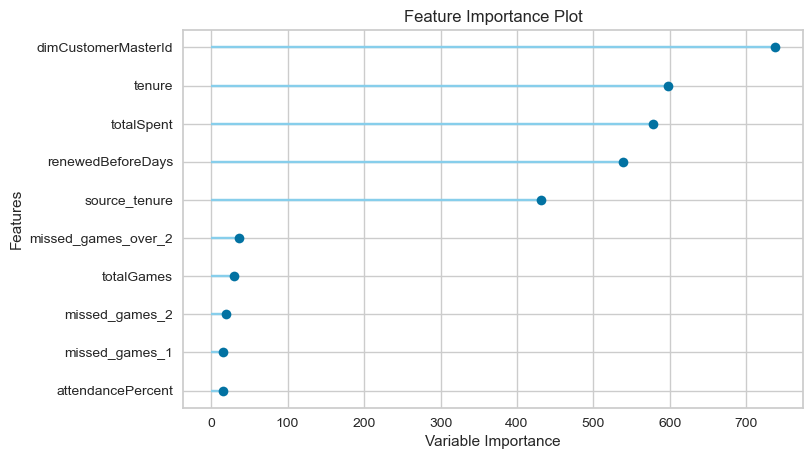

In [14]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?